<a href="https://colab.research.google.com/github/FreNzQuiN/Collab_Stable-Diffusion/blob/main/MyLatestInlineSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title #**1.1 START TEXT2IMG SD**
!pip install -q --upgrade diffusers invisible_watermark transformers accelerate safetensors compel
import torch
from torch import autocast
from diffusers import StableDiffusionXLPipeline, DDIMScheduler #EulerAncestralDiscreteScheduler,

# model = "linaqruf/animagine-xl"
# pipe = StableDiffusionXLPipeline.from_pretrained(
#     model,
#     torch_dtype=torch.float16,
#     use_safetensors=True,
#     safety_checker = None,
#     requires_safety_checker = False,
#     variant="fp16",
#     )

pipe = StableDiffusionXLPipeline.from_pretrained(
    "cagliostrolab/animagine-xl-4.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    custom_pipeline="lpw_stable_diffusion_xl",
    add_watermarker=False
    )

pipe.scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe.to('cuda')


In [ ]:
#@title #**1.2 START IMG2IMG SD**
from diffusers import StableDiffusionXLImg2ImgPipeline
from diffusers.utils import load_image

pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe.to("cuda")
pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

In [117]:
num=0
prompt_num=3
def disabled_safety_checker(images, clip_input):
    if len(images.shape)==4:
        num_images = images.shape[0]
        return images, [False]*num_images
    else:
        return images, False
pipe.safety_checker = disabled_safety_checker

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

It took 0.0 minutes 37 seconds!


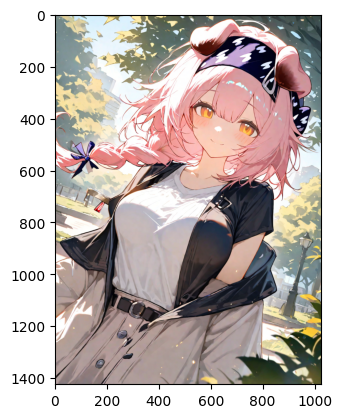

In [121]:
#@title #**2.1 PLAY TEXT2IMG SD**
from compel import Compel, ReturnedEmbeddingsType
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import math
import torch, gc

textFile = open(f"prompt{prompt_num}.txt", "a")

amount = 25 #@param {type:'integer'}
prompt = "1girl, goldenglow \(arknights\), arknights \(series\), dutch angle, looking at viewer, cgdct, cute, solo, smile, light particles, casual, beautiful background, blush, outdoors, park, medium breast, from front, depth of field, very smooth line, year 2024, masterpiece, high score, great score, absurdres" #@param {type:'string'}
negative_prompt = "lowres, bad anatomy, bad hands, text, error, missing finger, extra digits, fewer digits, cropped, worst quality, low quality, low score, bad score, average score, signature, watermark, username, blurry" #@param {type:'string'}
outputbase = "/content/anime_girl" #@param {type:'string'}
startNum = num

# compel = Compel(
#   tokenizer=[pipe.tokenizer, pipe.tokenizer_2] ,
#   text_encoder=[pipe.text_encoder, pipe.text_encoder_2],
#   returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
#   requires_pooled=[False, True]
# )
# conditioning, pooled = compel(prompt)
W = 1024 #@param {type:'integer'}
H = 1424 #@param {type:'integer'}
guidance_scale = 5 #@param {type:'number'}
guidance_rescale = 0.9 #@param {type:'number'}
num_inference_steps = 28 #@param {type:'integer'}
rand = True #@param {type:'boolean'}
start = time.time()
arrayTime = []

for x in range(amount):
  gc.collect()
  torch.cuda.empty_cache()
  start = time.time()
  if rand == True:
    setseed = random.randint(100000,10000000)
  else:
    seed = 6 #@param {type:'integer'}
    setseed = seed
  image = pipe(
      # prompt_embeds=conditioning, pooled_prompt_embeds=pooled,
      prompt=prompt,
      negative_prompt=negative_prompt,
      seed=setseed,
      width=W,
      height=H,
      guidance_scale=guidance_scale,
      guidance_rescale=guidance_rescale,
      target_size=(W,H),
      original_size=(4096,4096),
      num_inference_steps=num_inference_steps,
      truncation=True
      ).images[0]
  output=f"{outputbase}{num}_{setseed}.png"
  image.save(output)
  image = Image.open(output)
  plt.imshow(image)
  end = time.time()
  length = end - start
  arrayTime.append(length)
  num=num+1

end = time.time()
length = end - start
print("It took", math.floor(length/60), "minutes", math.floor(length%60), "seconds!")
textFile.write(f"\n\nTITLE: {startNum}--{num-1} {outputbase} {W}x{H}px\n + {prompt}\n - {negative_prompt}\n guide scale/rescale: {guidance_scale}/{guidance_rescale}\n steps: {num_inference_steps}\nIt took {math.floor(length/60)} minutes {math.floor(length%60)} seconds!")
textFile.close()
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#@title #**2.2 PLAY IMG2IMG SD COMING SOON**
url = ""
init_image = load_image(url).convert("RGB")
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt, image=init_image).images

In [ ]:
!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
#@title **REMOVE ALL**
!rm "/content/"*.png

In [ ]:
!rm f"/content/{outputbase}{num-1}_{setseed}.png"

In [122]:
#@title **3.3 Connect & Save to Google Drive**
from google.colab import drive
import datetime

drive.mount('/content/drive')

x = datetime.datetime.now().strftime("%Y_%m_%d")
!mkdir "/content/drive/MyDrive/Colab Notebooks/{x}"

!mkdir "/content/drive/MyDrive/Colab Notebooks/{x}/prompt{prompt_num}"

!mv "/content/"*.png "/content/drive/MyDrive/Colab Notebooks/{x}/prompt{prompt_num}"
!mv "/content/"*.txt "/content/drive/MyDrive/Colab Notebooks/{x}/prompt{prompt_num}"

prompt_num = prompt_num + 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/drive/MyDrive/Colab Notebooks/2025_03_14’: File exists


In [ ]:
!mv /content/dir {dir}

In [ ]:
!mkdir outputs

In [ ]:
!mv "/content/"*.png "/content/outputs"

In [ ]:
!smi-nvidia